# Idealized Sensitivity Study

Throughout this document *unmodified* is unsed to describe the runs which used the original values of `LANDUSE.TBL`.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.dates import DateFormatter
from netCDF4 import Dataset
from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair,
                 get_basemap, latlon_coords, g_geoht, combine_files, ALL_TIMES)

# Suppress warnings so the notebook looks nice
import warnings
warnings.filterwarnings('ignore')

# Style for plotting
plt.style.use('default')

# N-ICE Measurements
## NOTE: SEB Measurements are in UTC
### Importing SEB dataset
Measurements_seb = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_sebData_v1.nc', decode_times = False)

### Longwave radiation into dataframes
M_downlw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_longwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])
M_uplw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_longwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lw'])

### Shortwave radiation into dataframes
M_downsw = pd.DataFrame(Measurements_seb.variables['surface_downwelling_shortwave_flux'].values, 
                        index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sw'])
M_upsw = pd.DataFrame(Measurements_seb.variables['surface_upwelling_shortwave_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sw'])

###  Calculating net radiation
M_net = (M_downlw['lw'] - M_uplw['lw']) + (M_downsw['sw'] - M_upsw['sw'])

### Sensible and latent heat flux into dataframes
M_lat = -pd.DataFrame(Measurements_seb.variables['surface_downward_latent_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['lh'])
M_sen = -pd.DataFrame(Measurements_seb.variables['surface_downward_sensible_heat_flux'].values, 
                      index = pd.to_datetime(Measurements_seb.variables['unix_time'].values, unit = 's'), columns = ['sh'])
## NOTE: sensible and latent heat flux negative to match WRF sign convention

# Set date format for plots throughout the notebook
myFmt = DateFormatter("%m/%d \n %H:%M:%S")


# Case 1 - Winter Clear

In [2]:
# Finding all wrfout file
fns = glob('/Volumes/seagate_desktop/idealized/case1/000101/wrfo*')

# Creating an empty list to append to
wrflist = list()

# Opening the wrfout files and appending them to the empty list
for fn in fns:
    wrflist.append(Dataset(fn))

# Defining start and end dates of case study
sdate = '2015-02-04'
edate = '2015-02-06' 

# Creating a mask for the above start and end date to be used later
sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

# Importing WRF variables
cldfra = getvar(wrflist, "QCLOUD", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
cldfra_df = pd.DataFrame(cldfra.values, index = cldfra.Time.values, columns = z)

## lh - latent heat flux
lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values)

## sh - sensible heat flux
sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values)

## lwdnb - downwelling longwave radiation
lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values)

## lwupb - upwelling longwave radiation
lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values)

## swdnb - downwelling shortwave radiation
swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values)

## swupb - upwelling shortwave radiation
swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values)

# MODIFIED

# Finding all wrfout file
fns = glob('/Volumes/seagate_desktop/idealized/landusetbl_modifications/1ClearWinter_000101/wrfo*')

# Creating an empty list to append to
wrflist = list()

# Opening the wrfout files and appending them to the empty list
for fn in fns:
    wrflist.append(Dataset(fn))

# Importing WRF variables
## QCloud - Cloud Water Mixing Ratio is kg/kg
cldfra_mod = getvar(wrflist, "QCLOUD", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z_mod = getvar(wrflist, "z").mean('south_north').mean('west_east')
cldfra_df_mod = pd.DataFrame(cldfra_mod.values, index = cldfra_mod.Time.values, columns = z_mod)

## lh - latent heat flux
lh_mod = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df_mod = pd.DataFrame(lh_mod.values, index = lh_mod.Time.values)

## sh - sensible heat flux
sh_mod = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df_mod = pd.DataFrame(sh_mod.values, index = sh_mod.Time.values)

## lwdnb - downwelling longwave radiation
lwdnb_mod = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df_mod = pd.DataFrame(lwdnb_mod.values, index = lwdnb_mod.Time.values)

## lwupb - upwelling longwave radiation
lwupb_mod = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df_mod = pd.DataFrame(lwupb_mod.values, index = lwupb_mod.Time.values)

## swdnb - downwelling shortwave radiation
swdnb_mod = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df_mod = pd.DataFrame(swdnb_mod.values, index = swdnb_mod.Time.values)

## swupb - upwelling shortwave radiation
swupb_mod = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df_mod = pd.DataFrame(swupb_mod.values, index = swupb_mod.Time.values)

In [3]:
wrfstat = xr.open_dataset('/Volumes/seagate_desktop/idealized/case1/000101/wrfstat_d01_2015-02-04_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
qc = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values)
sh = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), columns = ['sh'])
lh = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 22:00:00', freq = '30min'), columns = ['lh'])

wrfstat = xr.open_dataset('/Volumes/seagate_desktop/idealized/landusetbl_modifications/1ClearWinter_000101/wrfstat_d01_2015-02-04_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
qc_mod = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values)
sh_mod = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), columns = ['sh'])
lh_mod = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='2/4/2015 00:00:00', end='2/6/2015 21:00:00', freq = '30min'), columns = ['lh'])

## Clouds

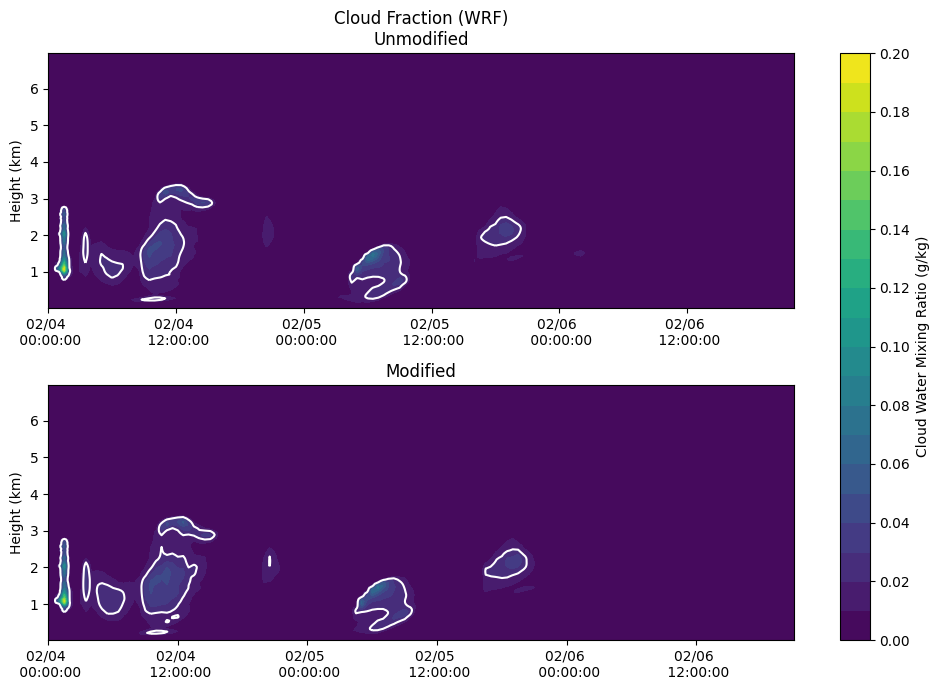

In [4]:
fig, axs = plt.subplots(2, figsize=(10,7))
levels = np.arange(0,0.21,0.01)

heatmap = axs[0].contourf(qc.index, qc.columns / 1000, qc.T.values * 1000, levels=levels)
contourmap = axs[0].contour(qc.index, qc.columns / 1000, qc.T.values * 1000, colors = ['white'], levels = [0.02])
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Cloud Fraction (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)

heatmap = axs[1].contourf(qc_mod.index, qc_mod.columns / 1000, qc_mod.T.values * 1000, levels=levels)
contourmap = axs[1].contour(qc_mod.index, qc_mod.columns / 1000, qc_mod.T.values * 1000, [0.02], colors = ['white'])
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)

plt.tight_layout()
cbar = fig.colorbar(heatmap, ax=axs[:])
cbar.set_ticks(np.arange(0,0.21,0.02))
cbar.set_label('Cloud Water Mixing Ratio (g/kg)')

plt.show()

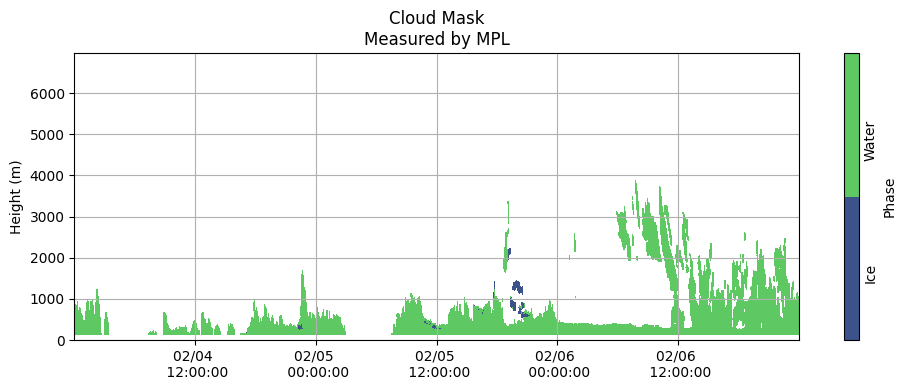

In [5]:
fns = ['/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150204.cdf',
       '/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150205.cdf',
       '/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150206.cdf']

measured_cloudmask_all = pd.DataFrame()

for fn in fns:
    rbt_cldmask = xr.open_dataset(fn)
    # Time is in UTC time stamp in fractional hours
    Time = rbt_cldmask.variables['DataTime'].values
    # Fix time to be a timestamp - Currently in hours
    yy = 2015
    mm = int(fn[-8:-6])
    dd = int(fn[-6:-4])
    date = [datetime(yy,mm,dd) + timedelta(seconds=hr*3600) for hr in Time[~np.isnan(Time)]]
    measured_cloudmask = pd.DataFrame(rbt_cldmask['PhaseMask'][~np.isnan(Time)].values, index = date, columns = rbt_cldmask['Range'])
    measured_cloudmask_all = pd.concat([measured_cloudmask_all, measured_cloudmask])

fig, ax = plt.subplots(figsize=(10,4))

plt.grid()
heatmap = plt.contourf(measured_cloudmask_all.index,
                       measured_cloudmask_all.columns, 
                       measured_cloudmask_all.T.values, 
                       [0, 1, 2])
# nan - no information
# 1 - cloud liquid
# 2 - cloud ice

plt.title('Cloud Mask\nMeasured by MPL')
plt.ylabel('Height (m)')
cbar = fig.colorbar(heatmap, label = 'Phase', ticks = [0.5, 1.5], orientation = 'vertical')
cbar.ax.set_yticklabels(['Ice', 'Water'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim(0, max(cldfra_df_mod.columns))
plt.tight_layout()
plt.show()

## Sensible and Latent Heat Flux

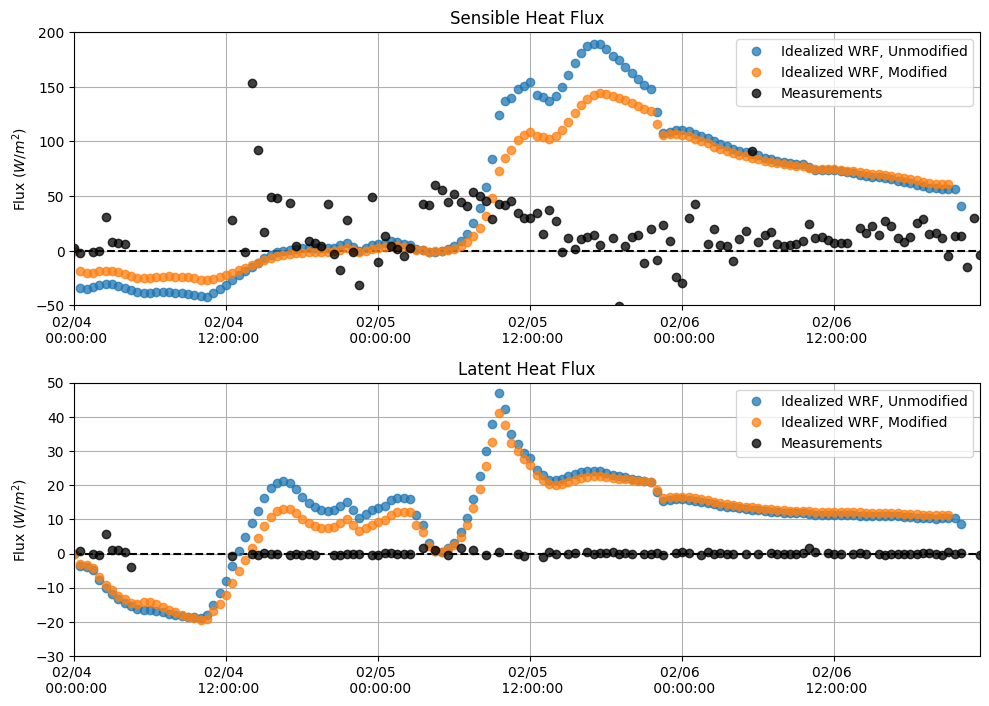

In [6]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.plot(sh_df, 'o', alpha = 0.75)
plt.plot(sh_df_mod, 'o', alpha = 0.75)
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Sensible Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(-50,200)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lh_df, 'o', alpha = 0.75)
plt.plot(lh_df_mod, 'o', alpha = 0.75)
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Latent Heat Flux')
plt.grid()
plt.ylim(-30,50)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

## Longwave Radiation

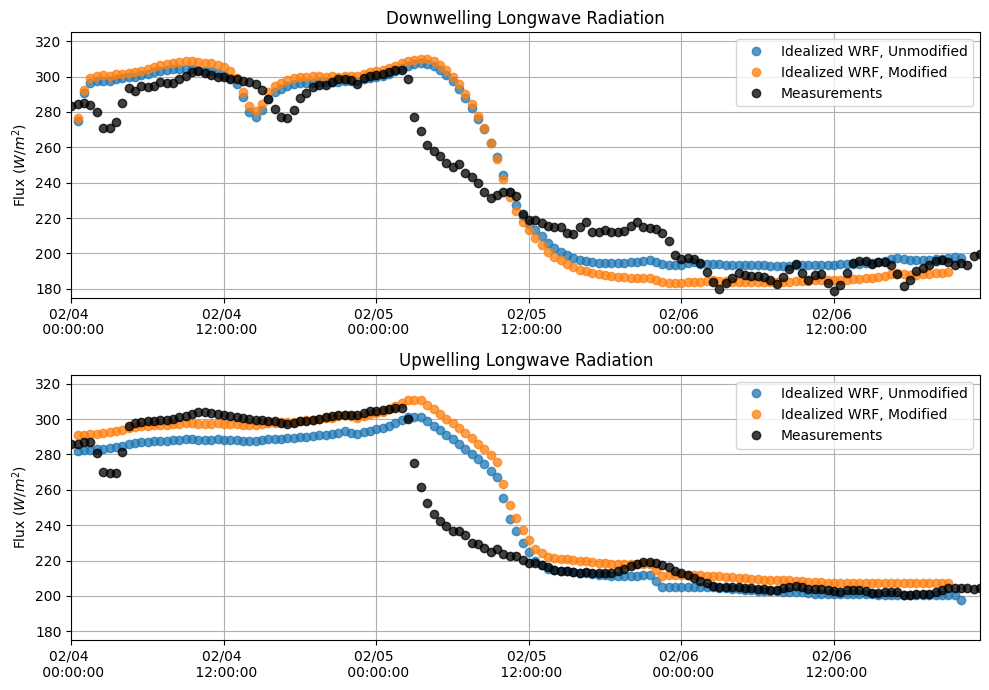

In [7]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(175,325)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(lwupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(175,325)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Summary Table
Red highlighting indicates the lowest correlation of that variable, green indicates the highest.

In [8]:
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[0]
lwdns['modified'] = lwdnb_df_mod[0]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[0]
lwups['modified'] = lwupb_df_mod[0]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[0]
swdns['modified'] = swdnb_df_mod[0]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[0]
swups['modified'] = swupb_df_mod[0]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[0]
lhs['modified'] = lh_df_mod[0]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[0]
shs['modified'] = sh_df_mod[0]

In [9]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave']).T
cc_1 = correlation_coefficients
r_squared = correlation_coefficients ** 2
rs_1 = r_squared
r_squared[1:].style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave
unmodified,0.000060,0.022658,0.715887,0.614063
modified,0.000228,0.042401,0.744958,0.609335


# Case 2 - Spring Cloudy

In [10]:
fns = glob('/Volumes/seagate_desktop/idealized/case4/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))
    
sdate = '2015-05-02'
edate = '2015-05-04' 

sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

cldfra = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
cldfra_df = pd.DataFrame(cldfra.values, index = cldfra.Time.values, columns = z)

lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values)

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values)

lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values)

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values)

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values)

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values)

# Finding all wrfout file
fns = glob('/Volumes/seagate_desktop/idealized/landusetbl_modifications/2CloudySpring_000101/wrfo*')

# Creating an empty list to append to
wrflist = list()

# Opening the wrfout files and appending them to the empty list
for fn in fns:
    wrflist.append(Dataset(fn))

cldfra_mod = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z_mod = getvar(wrflist, "z").mean('south_north').mean('west_east')
cldfra_df_mod = pd.DataFrame(cldfra_mod.values, index = cldfra_mod.Time.values, columns = z_mod)

## lh - latent heat flux
lh_mod = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df_mod = pd.DataFrame(lh_mod.values, index = lh_mod.Time.values)

## sh - sensible heat flux
sh_mod = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df_mod = pd.DataFrame(sh_mod.values, index = sh_mod.Time.values)

## lwdnb - downwelling longwave radiation
lwdnb_mod = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df_mod = pd.DataFrame(lwdnb_mod.values, index = lwdnb_mod.Time.values)

## lwupb - upwelling longwave radiation
lwupb_mod = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df_mod = pd.DataFrame(lwupb_mod.values, index = lwupb_mod.Time.values)

## swdnb - downwelling shortwave radiation
swdnb_mod = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df_mod = pd.DataFrame(swdnb_mod.values, index = swdnb_mod.Time.values)

## swupb - upwelling shortwave radiation
swupb_mod = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df_mod = pd.DataFrame(swupb_mod.values, index = swupb_mod.Time.values)

In [11]:
wrfstat = xr.open_dataset('/Volumes/seagate_desktop/idealized/case4/000101/wrfstat_d01_2015-05-02_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
qc = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values)
sh = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), columns = ['sh'])
lh = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 19:30:00', freq = '30min'), columns = ['lh'])

wrfstat = xr.open_dataset('/Volumes/seagate_desktop/idealized/landusetbl_modifications/2CloudySpring_000101/wrfstat_d01_2015-05-02_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
qc_mod = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values)
sh_mod = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), columns = ['sh'])
lh_mod = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='5/2/2015 00:00:00', end='5/4/2015 22:30:00', freq = '30min'), columns = ['lh'])

## Clouds

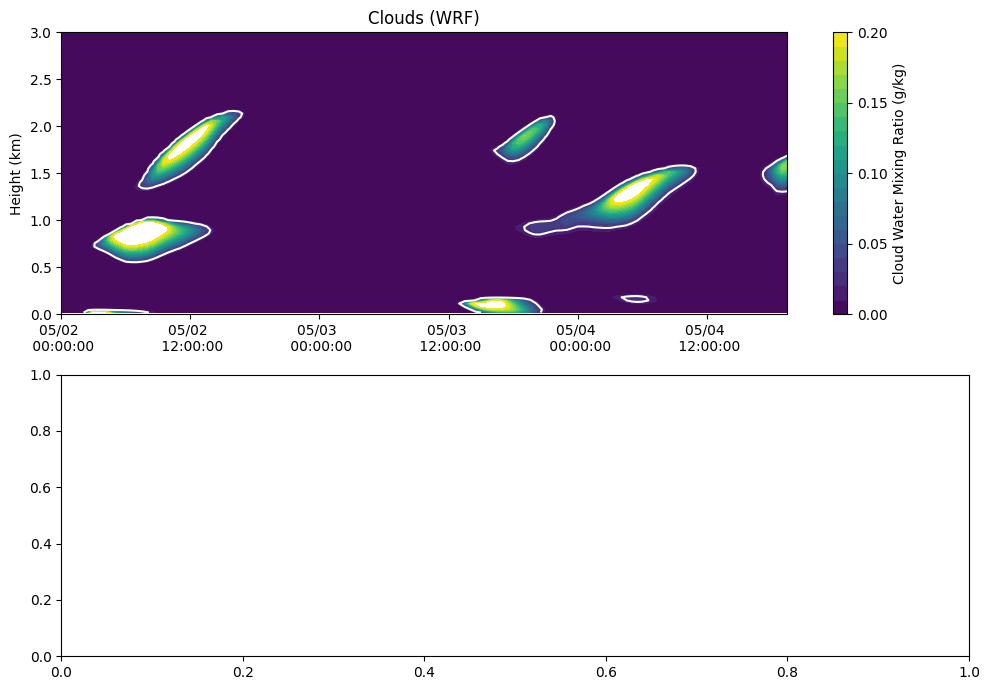

In [12]:
fig, axs = plt.subplots(2, figsize=(10,7))
levels = np.arange(0,0.21,0.01)

heatmap = axs[0].contourf(qc.index, qc.columns / 1000, qc.T.values * 1000, levels=levels)
contourmap = axs[0].contour(qc.index, qc.columns / 1000, qc.T.values * 1000, colors = ['white'], levels = [0.02])
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Clouds (WRF)')
axs[0].xaxis.set_major_formatter(myFmt)
axs[0].set_ylim(0,3)
plt.tight_layout()
cbar = fig.colorbar(heatmap, ax=axs[0])
cbar.set_ticks([0,0.05,0.1,0.15,0.2,0.25,0.3])
cbar.set_label('Cloud Water Mixing Ratio (g/kg)')

plt.show()

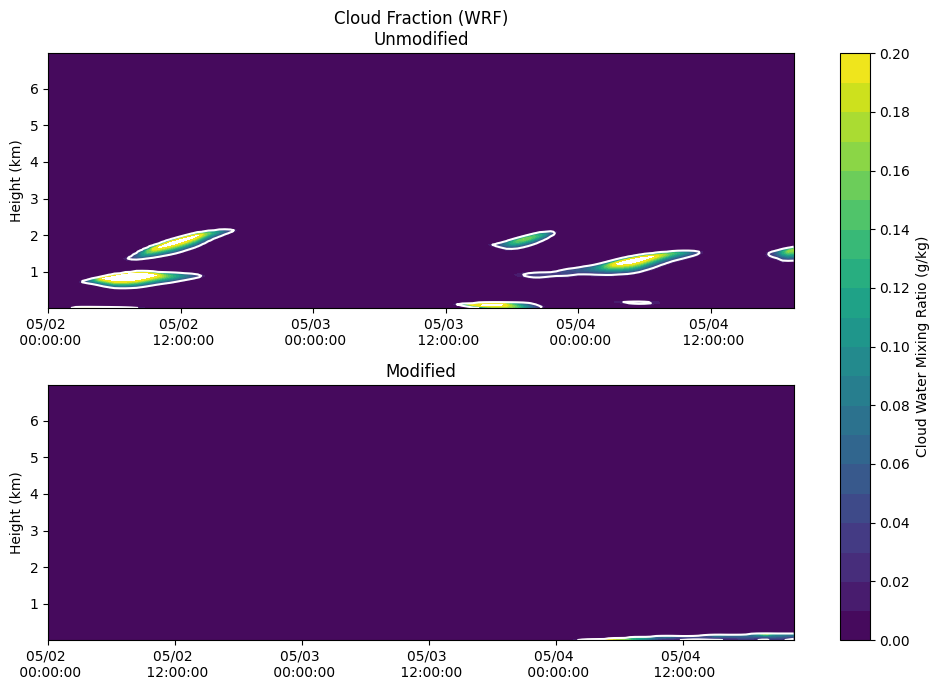

In [13]:
fig, axs = plt.subplots(2, figsize=(10,7))
levels = np.arange(0,0.21,0.01)

heatmap = axs[0].contourf(qc.index, qc.columns / 1000, qc.T.values * 1000, levels=levels)
contourmap = axs[0].contour(qc.index, qc.columns / 1000, qc.T.values * 1000, colors = ['white'], levels = [0.02])
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Cloud Fraction (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)

heatmap = axs[1].contourf(qc_mod.index, qc_mod.columns / 1000, qc_mod.T.values * 1000, levels=levels)
contourmap = axs[1].contour(qc_mod.index, qc_mod.columns / 1000, qc_mod.T.values * 1000, [0.02], colors = ['white'])
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)

plt.tight_layout()
cbar = fig.colorbar(heatmap, ax=axs[:])
cbar.set_ticks(np.arange(0,0.21,0.02))
cbar.set_label('Cloud Water Mixing Ratio (g/kg)')

plt.show()

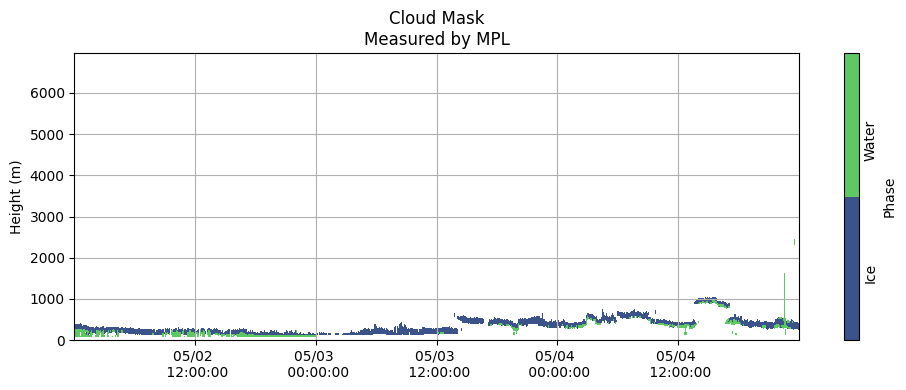

In [14]:
fns = ['/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150502.cdf',
       '/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150503.cdf',
       '/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150504.cdf']

measured_cloudmask_all = pd.DataFrame()

for fn in fns:
    rbt_cldmask = xr.open_dataset(fn)
    # Time is in UTC time stamp in fractional hours
    Time = rbt_cldmask.variables['DataTime'].values
    # Fix time to be a timestamp - Currently in hours
    yy = 2015
    mm = int(fn[-8:-6])
    dd = int(fn[-6:-4])
    date = [datetime(yy,mm,dd) + timedelta(seconds=hr*3600) for hr in Time[~np.isnan(Time)]]
    measured_cloudmask = pd.DataFrame(rbt_cldmask['PhaseMask'][~np.isnan(Time)].values, index = date, columns = rbt_cldmask['Range'])
    measured_cloudmask_all = pd.concat([measured_cloudmask_all, measured_cloudmask])

fig, ax = plt.subplots(figsize=(10,4))

plt.grid()
heatmap = plt.contourf(measured_cloudmask_all.index,
                       measured_cloudmask_all.columns, 
                       measured_cloudmask_all.T.values, 
                       [0, 1, 2])
# nan - no information
# 1 - cloud liquid
# 2 - cloud ice

plt.title('Cloud Mask\nMeasured by MPL')
plt.ylabel('Height (m)')
cbar = fig.colorbar(heatmap, label = 'Phase', ticks = [0.5, 1.5], orientation = 'vertical')
cbar.ax.set_yticklabels(['Ice', 'Water'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim(0, max(cldfra_df_mod.columns))
plt.tight_layout()
plt.show()

## Sensible and Latent Heat Flux

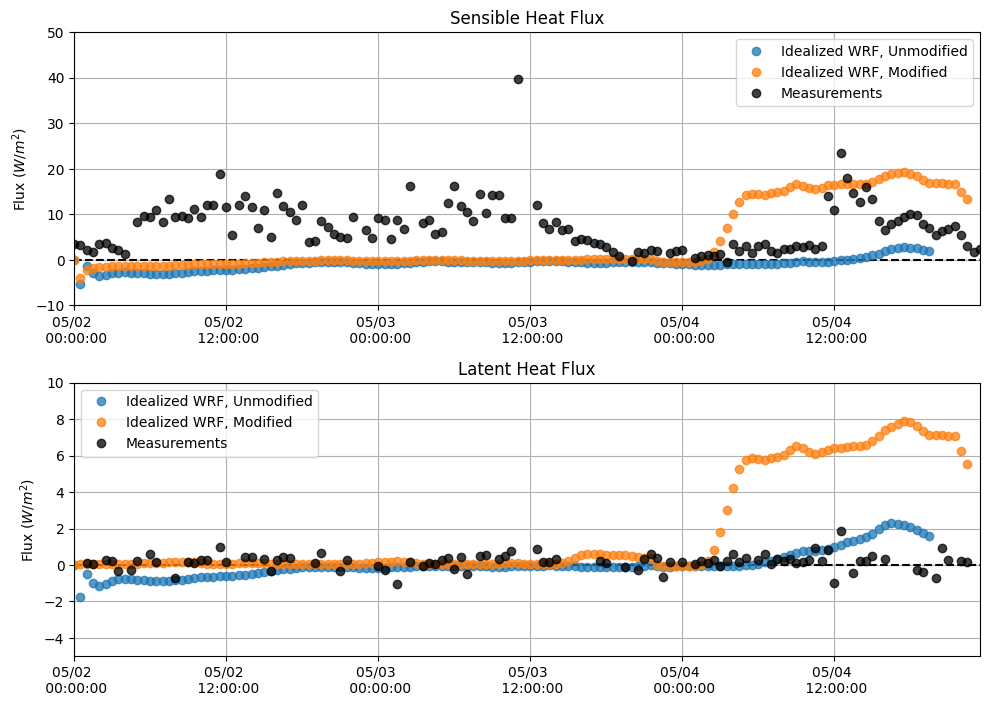

In [15]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.plot(sh_df, 'o', alpha = 0.75)
plt.plot(sh_df_mod, 'o', alpha = 0.75)
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Sensible Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(-10,50)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lh_df, 'o', alpha = 0.75)
plt.plot(lh_df_mod, 'o', alpha = 0.75)
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Latent Heat Flux')
plt.grid()
plt.ylim(-5,10)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

## Longwave and Shortwave Radiation

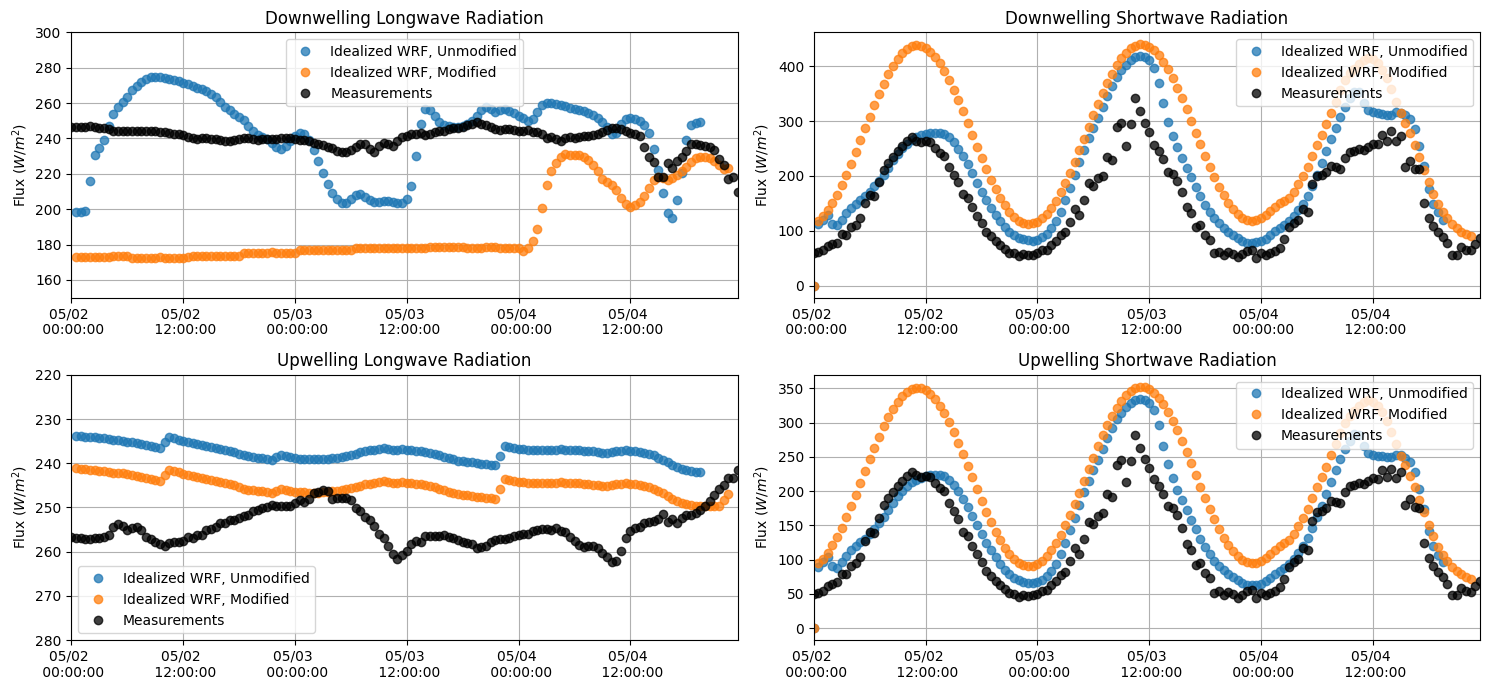

In [16]:
plt.figure(figsize = (15,7))
plt.subplot(221)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(150,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(223)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(lwupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(280,220)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(222)
plt.plot(swdnb_df, 'o', alpha = 0.75)
plt.plot(swdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Shortwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
#plt.ylim(180,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(224)
plt.plot(swupb_df, 'o', alpha = 0.75)
plt.plot(swupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Shortwave Radiation')
plt.grid()
#plt.ylim(180, 300)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Summary Table

Red highlighting indicates the lowest correlation of that variable, green indicates the highest.

In [17]:
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[0]
lwdns['modified'] = lwdnb_df_mod[0]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[0]
lwups['modified'] = lwupb_df_mod[0]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[0]
swdns['modified'] = swdnb_df_mod[0]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[0]
swups['modified'] = swupb_df_mod[0]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[0]
lhs['modified'] = lh_df_mod[0]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[0]
shs['modified'] = sh_df_mod[0]

In [18]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values,
                                         swdns.corr()['measured'].values,
                                         swups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave', 'Downwelling Shortwave', 'Upwelling Shortwave']).T
cc_2 = correlation_coefficients
r_squared = correlation_coefficients ** 2
rs_2 = r_squared
r_squared[1:].style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave,Downwelling Shortwave,Upwelling Shortwave
unmodified,0.001381,0.005242,0.091075,0.006432,0.885284,0.883314
modified,0.006193,0.000089,0.156495,0.009026,0.890261,0.899851


# Case 3 - Spring Clear

In [19]:
sdate = '2015-05-22'
edate = '2015-05-24' 

M_net = (M_downlw['lw'] - M_uplw['lw'])
sebmask = (M_downlw.index > sdate) & (M_downlw.index < edate)

fns = glob('/Volumes/seagate_desktop/idealized/case3/000101/wrfo*')
wrflist = list()
for fn in fns:
    wrflist.append(Dataset(fn))
    
cldfra = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z = getvar(wrflist, "z").mean('south_north').mean('west_east')
cldfra_df = pd.DataFrame(cldfra.values, index = cldfra.Time.values, columns = z)

lh = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df = pd.DataFrame(lh.values, index = lh.Time.values)

sh = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df = pd.DataFrame(sh.values, index = sh.Time.values)

lwdnb = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df = pd.DataFrame(lwdnb.values, index = lwdnb.Time.values)

lwupb = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df = pd.DataFrame(lwupb.values, index = lwupb.Time.values)

swdnb = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df = pd.DataFrame(swdnb.values, index = swdnb.Time.values)

swupb = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df = pd.DataFrame(swupb.values, index = swupb.Time.values)

# MODIFIED

# Finding all wrfout file
fns = glob('/Volumes/seagate_desktop/idealized/landusetbl_modifications/3ClearSpring_000101/wrfo*')

# Creating an empty list to append to
wrflist = list()

# Opening the wrfout files and appending them to the empty list
for fn in fns:
    wrflist.append(Dataset(fn))

# Importing WRF variables
## dbZ - for cloud plotting
cldfra_mod = getvar(wrflist, "CLDFRA", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
z_mod = getvar(wrflist, "z").mean('south_north').mean('west_east')
cldfra_df_mod = pd.DataFrame(cldfra_mod.values, index = cldfra_mod.Time.values, columns = z_mod)

## lh - latent heat flux
lh_mod = getvar(wrflist, "LH", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lh_df_mod = pd.DataFrame(lh_mod.values, index = lh_mod.Time.values)

## sh - sensible heat flux
sh_mod = getvar(wrflist, "HFX", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
sh_df_mod = pd.DataFrame(sh_mod.values, index = sh_mod.Time.values)

## lwdnb - downwelling longwave radiation
lwdnb_mod = getvar(wrflist, "LWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwdnb_df_mod = pd.DataFrame(lwdnb_mod.values, index = lwdnb_mod.Time.values)

## lwupb - upwelling longwave radiation
lwupb_mod = getvar(wrflist, "LWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
lwupb_df_mod = pd.DataFrame(lwupb_mod.values, index = lwupb_mod.Time.values)

## swdnb - downwelling shortwave radiation
swdnb_mod = getvar(wrflist, "SWDNB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swdnb_df_mod = pd.DataFrame(swdnb_mod.values, index = swdnb_mod.Time.values)

## swupb - upwelling shortwave radiation
swupb_mod = getvar(wrflist, "SWUPB", timeidx=ALL_TIMES, method="cat").mean('south_north').mean('west_east')
swupb_df_mod = pd.DataFrame(swupb_mod.values, index = swupb_mod.Time.values)

In [20]:
wrfstat = xr.open_dataset('/Volumes/seagate_desktop/idealized/case3/000101/wrfstat_d01_2015-05-22_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
qc = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values)
sh = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['sh'])
lh = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['lh'])


wrfstat = xr.open_dataset('/Volumes/seagate_desktop/idealized/landusetbl_modifications/3ClearSpring_000101/wrfstat_d01_2015-05-22_00:00:00')
cst_qc = wrfstat['CSP_QC']
cst_sh = wrfstat['CST_SH']
cst_lh = wrfstat['CST_LH']
cst_time = wrfstat['Times']
csp_z = wrfstat['CSP_Z']
qc_mod = pd.DataFrame(cst_qc.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), 
                  columns = csp_z.isel(Time = 1).values)
sh_mod = pd.DataFrame(cst_sh.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['sh'])
lh_mod = pd.DataFrame(cst_lh.values, 
                  index = pd.date_range(start='5/22/2015 00:00:00', end='5/24/2015 22:30:00', freq = '30min'), columns = ['lh'])

## Clouds

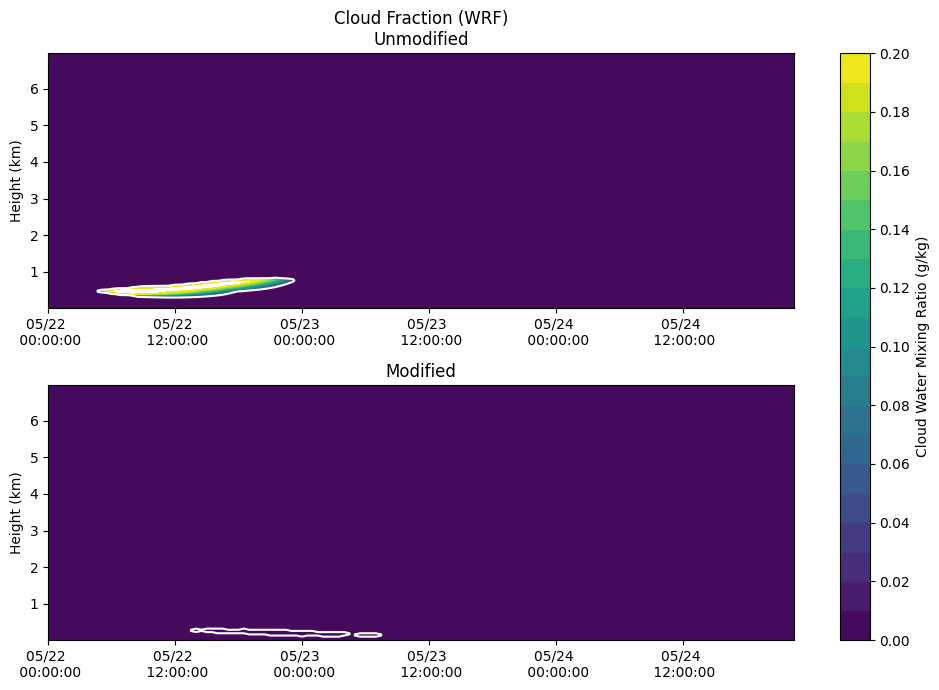

In [21]:
fig, axs = plt.subplots(2, figsize=(10,7))
levels = np.arange(0,0.21,0.01)

heatmap = axs[0].contourf(qc.index, qc.columns / 1000, qc.T.values * 1000, levels=levels)
contourmap = axs[0].contour(qc.index, qc.columns / 1000, qc.T.values * 1000, colors = ['white'], levels = [0.02])
axs[0].set_ylabel('Height (km)')
axs[0].set_title('Cloud Fraction (WRF)\nUnmodified')
axs[0].xaxis.set_major_formatter(myFmt)

heatmap = axs[1].contourf(qc_mod.index, qc_mod.columns / 1000, qc_mod.T.values * 1000, levels=levels)
contourmap = axs[1].contour(qc_mod.index, qc_mod.columns / 1000, qc_mod.T.values * 1000, [0.02], colors = ['white'])
axs[1].set_ylabel('Height (km)')
axs[1].set_title('Modified')
axs[1].xaxis.set_major_formatter(myFmt)

plt.tight_layout()
cbar = fig.colorbar(heatmap, ax=axs[:])
cbar.set_ticks(np.arange(0,0.21,0.02))
cbar.set_label('Cloud Water Mixing Ratio (g/kg)')

plt.show()

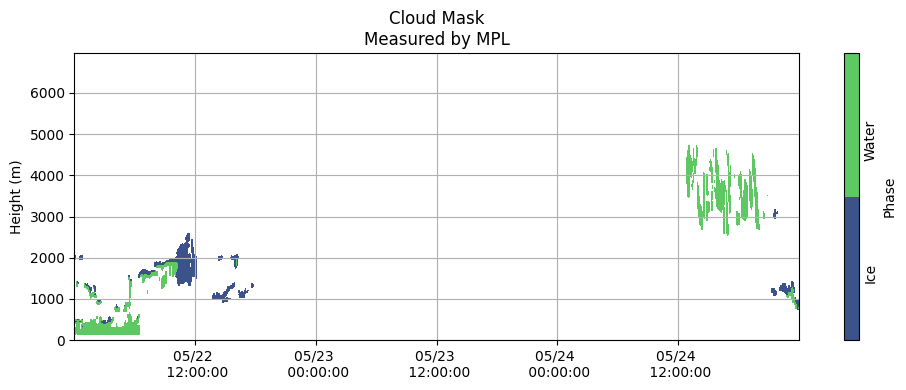

In [22]:
fns = ['/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150522.cdf',
       '/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150523.cdf',
       '/Volumes/seagate_desktop/data/MPL/Robert_MPLData/FinalNICELidarData/NICE_MPLDataFinal20150524.cdf']

measured_cloudmask_all = pd.DataFrame()

for fn in fns:
    rbt_cldmask = xr.open_dataset(fn)
    # Time is in UTC time stamp in fractional hours
    Time = rbt_cldmask.variables['DataTime'].values
    # Fix time to be a timestamp - Currently in hours
    yy = 2015
    mm = int(fn[-8:-6])
    dd = int(fn[-6:-4])
    date = [datetime(yy,mm,dd) + timedelta(seconds=hr*3600) for hr in Time[~np.isnan(Time)]]
    measured_cloudmask = pd.DataFrame(rbt_cldmask['PhaseMask'][~np.isnan(Time)].values, index = date, columns = rbt_cldmask['Range'])
    measured_cloudmask_all = pd.concat([measured_cloudmask_all, measured_cloudmask])

fig, ax = plt.subplots(figsize=(10,4))

plt.grid()
heatmap = plt.contourf(measured_cloudmask_all.index,
                       measured_cloudmask_all.columns, 
                       measured_cloudmask_all.T.values, 
                       [0, 1, 2])
# nan - no information
# 1 - cloud liquid
# 2 - cloud ice

plt.title('Cloud Mask\nMeasured by MPL')
plt.ylabel('Height (m)')
cbar = fig.colorbar(heatmap, label = 'Phase', ticks = [0.5, 1.5], orientation = 'vertical')
cbar.ax.set_yticklabels(['Ice', 'Water'], rotation = 90)
cbar.ax.tick_params(size=0)
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylim(0, max(cldfra_df_mod.columns))
plt.tight_layout()
plt.show()

## Sensible and Latent Heat Flux

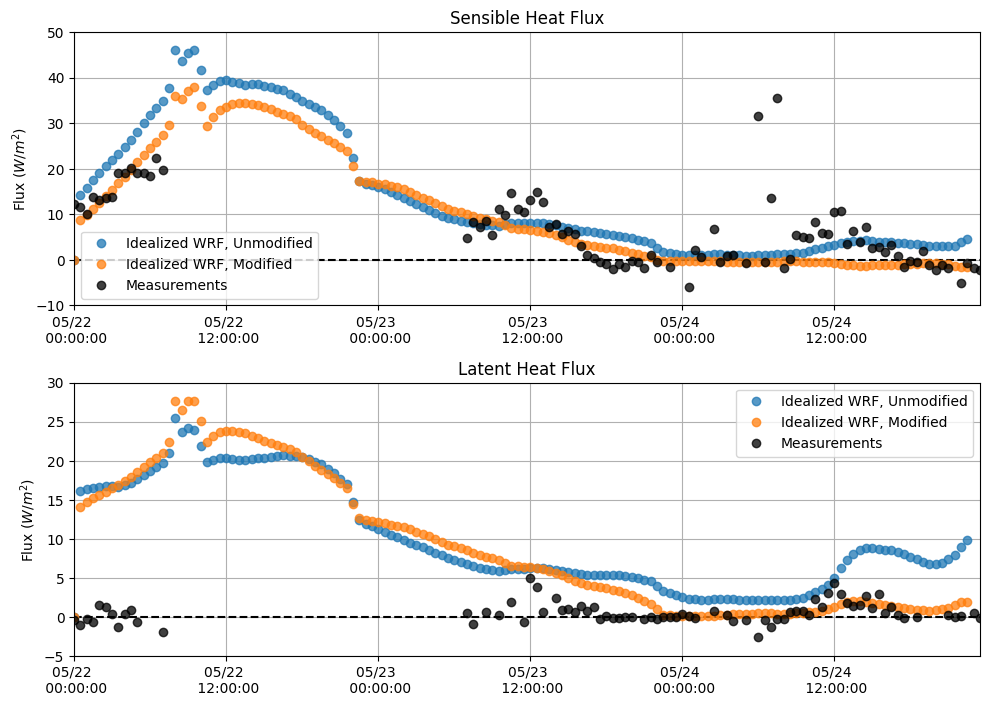

In [23]:
plt.figure(figsize = (10,7))
plt.subplot(211)
plt.plot(sh_df, 'o', alpha = 0.75)
plt.plot(sh_df_mod, 'o', alpha = 0.75)
plt.plot(M_sen[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Sensible Heat Flux')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(-10,50)
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(212)
plt.plot(lh_df, 'o', alpha = 0.75)
plt.plot(lh_df_mod, 'o', alpha = 0.75)
plt.plot(M_lat[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.hlines(0, xmin = M_lat[sdate:edate].index[0], xmax = M_lat[sdate:edate].index[-1], linestyle = '--', color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Latent Heat Flux')
plt.grid()
plt.ylim(-5,30)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_lat[sdate:edate].index[0],M_lat[sdate:edate].index[-1])
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(myFmt)
plt.show()

## Longwave and Shortwave Radiation

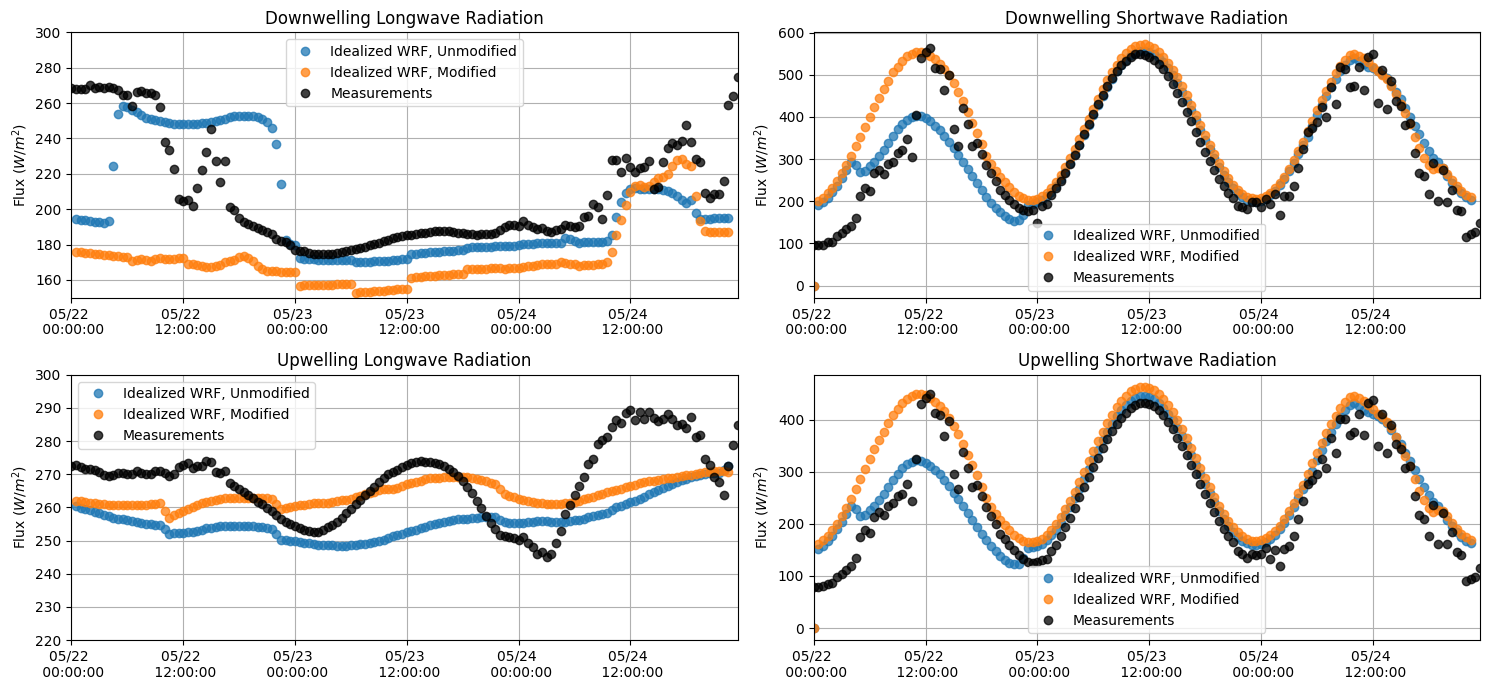

In [24]:
plt.figure(figsize = (15,7))
plt.subplot(221)
plt.plot(lwdnb_df, 'o', alpha = 0.75)
plt.plot(lwdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downlw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Longwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.ylim(150,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(223)
plt.plot(lwupb_df, 'o', alpha = 0.75)
plt.plot(lwupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_uplw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Longwave Radiation')
plt.grid()
plt.ylim(220,300)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(222)
plt.plot(swdnb_df, 'o', alpha = 0.75)
plt.plot(swdnb_df_mod, 'o', alpha = 0.75)
plt.plot(M_downsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Downwelling Shortwave Radiation')
plt.grid()
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
#plt.ylim(180,300)
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)

plt.subplot(224)
plt.plot(swupb_df, 'o', alpha = 0.75)
plt.plot(swupb_df_mod, 'o', alpha = 0.75)
plt.plot(M_upsw[sdate:edate], 'o', alpha = 0.75, color = 'k')
plt.ylabel('Flux $(W/m^{2})$')
plt.title('Upwelling Shortwave Radiation')
plt.grid()
#plt.ylim(180, 300)
plt.legend(['Idealized WRF, Unmodified', 'Idealized WRF, Modified', 'Measurements'])
plt.xlim(M_downlw[sdate:edate].index[0],M_downlw[sdate:edate].index[-1])
plt.gca().xaxis.set_major_formatter(myFmt)
plt.tight_layout()
plt.show()

## Summary Table
Red highlighting indicates the lowest correlation of that variable, green indicates the highest.

In [25]:
lwdns = M_downlw[sdate:edate]
lwdns.columns = ['measured']
lwdns['unmodified'] = lwdnb_df[0]
lwdns['modified'] = lwdnb_df_mod[0]

lwups = M_uplw[sdate:edate]
lwups.columns = ['measured']
lwups['unmodified'] = lwupb_df[0]
lwups['modified'] = lwupb_df_mod[0]

swdns = M_downsw[sdate:edate]
swdns.columns = ['measured']
swdns['unmodified'] = swdnb_df[0]
swdns['modified'] = swdnb_df_mod[0]

swups = M_upsw[sdate:edate]
swups.columns = ['measured']
swups['unmodified'] = swupb_df[0]
swups['modified'] = swupb_df_mod[0]

lhs = M_lat[sdate:edate]
lhs.columns = ['measured']
lhs['unmodified'] = lh_df[0]
lhs['modified'] = lh_df_mod[0]

shs = M_sen[sdate:edate]
shs.columns = ['measured']
shs['unmodified'] = sh_df[0]
shs['modified'] = sh_df_mod[0]

In [26]:
correlation_coefficients = pd.DataFrame([lhs.corr()['measured'].values, 
                                         shs.corr()['measured'].values,
                                         lwdns.corr()['measured'].values,
                                         lwups.corr()['measured'].values,
                                         swdns.corr()['measured'].values,
                                         swups.corr()['measured'].values], 
                                         columns = lhs.corr().columns,
                                         index = ['Latent', 'Sensible', 'Downwelling Longwave', 'Upwelling Longwave', 'Downwelling Shortwave', 'Upwelling Shortwave']).T
cc_3 = correlation_coefficients
r_squared = correlation_coefficients ** 2
rs_3 = r_squared
r_squared[1:].style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave,Downwelling Shortwave,Upwelling Shortwave
unmodified,0.003616,0.360722,0.142917,0.011557,0.801807,0.803250
modified,0.017562,0.398966,0.070061,0.001145,0.821090,0.840806


## Statistics and Summary

In [27]:
mean_cc = (cc_3.iloc[:,0:4] + cc_2.iloc[:,0:4] + cc_1)/2
mean_cc_sw = ((cc_3.iloc[:,4:6] + cc_2.iloc[:,4:6])/2)
mean_cc = pd.concat([mean_cc, mean_cc_sw])

mean_rs = (rs_3.iloc[:,0:4] + rs_2.iloc[:,0:4] + rs_1)/2
mean_rs_sw = ((rs_3.iloc[:,4:6] + rs_2.iloc[:,4:6])/2)
mean_rs = pd.concat([mean_rs, mean_rs_sw], axis=1, join="inner")

mean_rs[1:].style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'pink', axis = 0)

,Latent,Sensible,Downwelling Longwave,Upwelling Longwave,Downwelling Shortwave,Upwelling Shortwave
unmodified,0.002528,0.194311,0.474940,0.316026,0.843545,0.843282
modified,0.011992,0.220728,0.485757,0.309753,0.855676,0.870328


On average, the modified $R^{2}$ values are *slightly* better than unmodified for most categories, the most notable difference being in the upwelling shortwave likely due to the correction in downwelling shortave and increased albedo. 